# Hello GPX File

## Define Helpers

In [1]:
import math
import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def distance(lat1, lon1, lat2, lon2):
    earthRadius = 6371000

    dLat = math.radians(lat2-lat1)
    dLon = math.radians(lon2-lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)

    a = math.sin(dLat/2) * math.sin(dLat/2) + math.sin(dLon/2) * math.sin(dLon/2) * math.cos(lat1) * math.cos(lat2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
  
    return earthRadius * c

def gain(elevation_delta):
    if elevation_delta > 0:
        return elevation_delta
    else:
        return 0

def time_delta(t1, t0):
    if t0 is pd.NaT:
        return int(0)
    else:
        return datetime.timedelta.total_seconds(t1-t0)

def distance_to_segment(value):
    if math.isnan(value):
        return int(0)
    else:
        return int(value/100)

## Load File

In [4]:
import sys
!{sys.executable} -m pip install gpxpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 111 kB 8.0 MB/s 
  Created wheel for gpxpy: filename=gpxpy-1.5.0-py3-none-any.whl size=42898 sha256=c5d32dbf66d98ea8a5ad8772be93011dee0271fa337374b7109ab36509adbbdf
  Stored in directory: /root/.cache/pip/wheels/78/49/b6/d1851fcb4ee10fa784325d7fcf6c97789157c706ab3a71e2b6
Successfully built gpxpy


In [6]:
import gpxpy
import gpxpy.gpx

gpx_file = open('3_Zinnenlauf_.gpx', 'r')
gpx = gpxpy.parse(gpx_file)

## Create Dataframe

In [7]:
cols = [ 'lat', 'lon', 'elevation', 'time' ]
idx = []
rows = []

row = 0
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            idx.append(row)
            rows.append([point.latitude, point.longitude, point.elevation, point.time])
            row = row + 1
            
base = pd.DataFrame(data=rows, index=idx, columns=cols)

base['elevation_delta'] = base.elevation.diff().shift(0)

base['time_prev'] = base.time.shift(+1)
base['time_delta'] = base.apply(
    lambda row: time_delta(row['time'], row['time_prev']), axis=1)
del base['time']
del base['time_prev']


base['lat_prev'] = base.lat.shift(+1)
base['lon_prev'] = base.lon.shift(+1)
base['distance_delta'] = base.apply(
    lambda row: distance(row['lat'],row['lon'], row['lat_prev'],row['lon_prev']), axis=1)
del base['lat_prev']
del base['lon_prev']

base['distance_sum'] = base['distance_delta'].cumsum(axis = 0)
base['distance_segment'] = base.apply(
    lambda row: distance_to_segment(row['distance_sum']), axis=1)

base.tail(10)

,lat,lon,elevation,elevation_delta,time_delta,distance_delta,distance_sum,distance_segment
7154,46.636961,12.310763,2404.6,0.4,1.0,1.202613,16968.922968,169
7155,46.636969,12.310765,2405.2,0.6,1.0,0.902570,16969.825537,169
7156,46.636985,12.310768,2405.4,0.2,1.0,1.793802,16971.619339,169
7157,46.636986,12.310774,2405.6,0.2,1.0,0.471393,16972.090733,169
7158,46.636982,12.310770,2405.4,-0.2,1.0,0.539532,16972.630264,169
7159,46.636982,12.310772,2405.4,0.0,1.0,0.152697,16972.782961,169
7160,46.636976,12.310743,2405.2,-0.2,1.0,2.312440,16975.095402,169
7161,46.637001,12.310782,2405.4,0.2,6.0,4.073541,16979.168943,169
7162,46.637008,12.310782,2405.4,0.0,1.0,0.778364,16979.947308,169
7163,46.637017,12.310778,2405.4,0.0,1.0,1.046315,16980.993622,169


## Group Dataframe (per 100m)

In [11]:
base_g = base.groupby('distance_segment').agg(
    {
        'elevation': ['mean'],
        'elevation_delta': ['sum'],
        'distance_delta': ['sum'], 
        'time_delta': ['sum']})
base_g['pace_segment'] = 16.7/(base_g[('distance_delta','sum')]/base_g[('time_delta','sum')])
base_g['time_sum'] = base_g['time_delta'].cumsum(axis = 0)/3600
base_g.head(10)

,elevation,elevation_delta,distance_delta,time_delta,pace_segment,time_sum
,mean,sum,sum,sum,,
distance_segment,,,,,,
0,1316.168000,-0.8,99.173515,26.0,4.378185,0.007222
1,1314.416667,-1.0,97.714704,24.0,4.101737,0.013889
2,1314.216667,0.6,99.981768,24.0,4.008731,0.020556
3,1314.920000,-0.8,99.198336,25.0,4.208740,0.027500
4,1312.550000,-2.8,100.542371,24.0,3.986379,0.034167
5,1309.416000,-2.8,102.293517,25.0,4.081393,0.041111
6,1307.575000,-1.6,97.440168,24.0,4.113293,0.047778
7,1306.046154,-0.6,102.259214,26.0,4.246072,0.055000


## Plot Dataframe

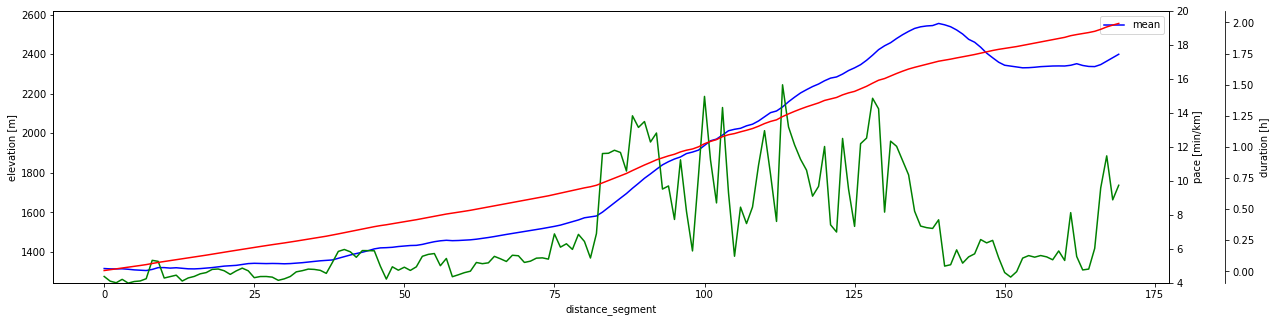

In [12]:
fig,ax = plt.subplots()

ax.set_ylabel('elevation [m]')
ax.set_xlabel('segments [100m]')

ax2 = ax.twinx()
ax2.set_ylim(4, 20)
ax2.set_ylabel('pace [min/km]')
ax3 = ax.twinx()
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.05))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
ax3.set_ylabel('duration [h]')


base_g['elevation'].plot(ax=ax, style='b-', figsize=(20,5))
base_g['pace_segment'].plot(ax=ax2, style='g-')
base_g['time_sum'].plot(ax=ax3, style='r-')